In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import plot_roc_curve
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics.pairwise import linear_kernel
from sklearn.decomposition import NMF, PCA

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (confusion_matrix, precision_score, 
                                    recall_score, accuracy_score, r2_score, 
                                    plot_confusion_matrix)

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, plot_confusion_matrix
from sklearn.cluster import DBSCAN

from sklearn import (
    cluster, decomposition, ensemble, manifold, 
    random_projection, preprocessing)
from sklearn.utils.class_weight import compute_class_weight

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB

# from sklearn.neighbors import KNeighborsRegressor

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import pickle
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
import random

In [2]:
cd ..

/home/heather/galvanize/Capstone2/Capstone2_git_fix/Capstone2_temp_name


In [3]:
from src.helper_functions import plot_word_cloud, \
                                plot_roc_curves_get_score_data,\
                                gridsearch_with_output, \
                                orig_vect                                    

### Data and Sample DF

In [4]:
df = pd.read_csv('../../cleaned_comments.csv')

In [ ]:
#Utilize 1/15 of data
# sample_df = pd.read_csv('../../sample_df.csv')

## Imbalanced fixed through oversampling

In [113]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.rating, stratify = df.rating, test_size=0.4)
y_train.value_counts()
#Rejected values utilize only 7 percent of the overall available data

len(y_test)/(len(y_test)+len(y_train))

0.40000033216779346

In [114]:
train_df = pd.concat([X_train, y_train], axis = 1)
ap_df = train_df[train_df.rating ==1]
rej_df = train_df[train_df.rating == 0]
#check your work
ap_df.rating.value_counts(), rej_df.rating.value_counts()

(1    1011387
 Name: rating, dtype: int64,
 0    72402
 Name: rating, dtype: int64)

In [115]:
max_val = ap_df.rating.value_counts()[1]
max_val

1011387

In [116]:
#try to oversampling the minority class?
over_rej = rej_df.sample(n = max_val, replace = True)
over_rej.rating.value_counts()

0    1011387
Name: rating, dtype: int64

In [117]:
fixed_train_df = pd.concat([over_rej, ap_df], axis = 0)

In [118]:
shuffled_df = fixed_train_df.sample(frac=1)

In [119]:
X_train = shuffled_df.text.values
y_train = shuffled_df.rating.values


In [120]:
len(y_test)/(len(y_train)+len(y_test))

0.2631868053812678

## OR Imbalance fixed through undersampling

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.rating, stratify = df.rating, test_size=0.06)
y_train.value_counts()
#Rejected values utilize only 7 percent of the overall available data

len(y_test)/(len(y_test)+len(y_train))

0.06000002214451956

In [6]:
train_df = pd.concat([X_train, y_train], axis = 1)
ap_df = train_df[train_df.rating ==1]
rej_df = train_df[train_df.rating == 0]
#check your work
ap_df.rating.value_counts(), rej_df.rating.value_counts()

(1    1584507
 Name: rating, dtype: int64,
 0    113430
 Name: rating, dtype: int64)

In [7]:
#try to undersampling the majority class?
min_val = rej_df.rating.value_counts()[0]
r = np.random.RandomState(42)
inds = np.arange(min_val)
r.shuffle(inds)
rej_df1=rej_df.iloc[inds]
ap_df1=ap_df.iloc[inds]
#put indices in a random order for selection
fixed_train_df = pd.concat([rej_df1, ap_df1], axis = 0)

In [8]:
shuffled_df = fixed_train_df.sample(frac=1)

In [9]:
shuffled_df.rating.value_counts()

1    113430
0    113430
Name: rating, dtype: int64

In [10]:
X_train = shuffled_df.text.values
y_train = shuffled_df.rating.values
shuffled_df.rating.value_counts()

1    113430
0    113430
Name: rating, dtype: int64

In [11]:
len(y_test)/(len(y_train)+len(y_test))

0.3232887581695447

## Train Test Split with Vectorizing 

In [12]:
vectorizer, x_train_vect = orig_vect(X_train)

#### Only transform your test set on your vectorizer

In [14]:
x_test_vect = vectorizer.transform(X_test.values)

## Try New vectorizing methods

In [15]:
#in Google Colab

Best parameters set:
[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.25, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)), ('clf', OneVsRestClassifier(estimator=ComplementNB(alpha=1.0, class_prior=None,
                                           fit_prior=True, norm=False),
                    n_jobs=None))]

## Random Forest with Balanced Classes
x_train_vect, x_test_vect, y_train, y_test

In [16]:
model2 = RandomForestClassifier(n_jobs=-1, 
                               random_state  = 1,
                               max_depth = 4, 
                               n_estimators=500, 
                              max_features = 500, 
                              min_samples_split = 2,
                              bootstrap = True,
                              min_samples_leaf = 1)
model2.fit(x_train_vect, y_train)

# max_depth            | 4        | [3, 2, 4]
# min_samples_split    | 2        | [2, 4]
# min_samples_leaf     | 1        | [1, 2, 4]
# bootstrap            | True     | [True, False]

RandomForestClassifier(max_depth=4, max_features=500, n_estimators=500,
                       n_jobs=-1, random_state=1)

### Save model

In [17]:
# filename = 'balanced_rf_model.sav'
# pickle.dump(model, open(filename, 'wb'))

In [18]:
rf_y_pred = model2.predict(x_test_vect)

accuracy_score(y_test, rf_y_pred), \
    precision_score(y_test, rf_y_pred), \
           recall_score(y_test, rf_y_pred)

(0.9041604000775058, 0.9390772565412603, 0.9595507173296157)

b4 GS: (0.8306501616546348, 0.9444945499523282, 0.8696570296465899)

aftter GS: (0.8317463129456575, 0.9446224727488, 0.8707721874888781) &

with better n_features:(0.8952787988839187, 0.9390361276086293, 0.9493995348174871)

full_dataset
(0.8969090428454577, 0.939293085693108, 0.9509921261711004)

gridsearch on 

In [19]:
rftn, rffp, rffn, rftp = confusion_matrix(y_test, rf_y_pred).ravel()
rftn, rffp, rffn, rftp

(944, 6296, 4091, 97048)

In [ ]:
n_feats= np.arange(1, 300, 50)
accuracies = []
recall = []
precision = []

for n in n_feats:
    
    model = RandomForestClassifier(n_jobs=-1, 
                               random_state  = 3,
                               max_depth = 3,  6
                               n_estimators = n, 
                              max_features = 100)
        
    model.fit(x_train_vect, y_train)
    y_pred = model.predict(x_train_vect)
    accuracies.append(accuracy_score(y_train, y_pred))
    recall.append(recall_score(y_train, y_pred))
    precision.append(precision_score(y_train, y_pred))

fig, ax = plt.subplots()
ax.plot(n_feats, accuracies, label = 'A')
ax.plot(n_feats, recall, label = 'R')
ax.plot(n_feats, precision, label = 'P')
ax.set_xlabel("Number of Estimators")
ax.set_ylabel("Scores")
ax.set_title('Scores vs Num Estimators')
# plt.savefig('RF_acur_v_feat.png')
plt.legend()
plt.show()


## Bernoulli Naive Bayes with Balanced Classes
x_train_vect, x_test_vect, y_train, y_test

In [20]:
nb = BernoulliNB()
nb.fit(x_train_vect, y_train)

BernoulliNB()

In [21]:
# filename = 'balanced_nb_model.sav'
# pickle.dump(nb, open(filename, 'wb'))

In [22]:
bnb_y_pred = nb.predict(x_test_vect)

In [23]:
accuracy_score(y_test, bnb_y_pred), \
    precision_score(y_test, bnb_y_pred), \
           recall_score(y_test, bnb_y_pred)


(0.49630463466169644, 0.9626309407859429, 0.4788360573072702)

In [24]:
tn, fp, fn, tp = confusion_matrix(y_test, bnb_y_pred).ravel()
tn, fp, fn, tp

(5360, 1880, 52710, 48429)

Way better at predicting positives than positives 

## ComplementNB

In [25]:
cnb = ComplementNB()
cnb.fit(x_train_vect, y_train)
# filename = 'balanced_cnb_model.sav'
# pickle.dump(nb, open(filename, 'wb'))


cnb_y_pred = cnb.predict(x_test_vect)

accuracy_score(y_test, cnb_y_pred), \
    precision_score(y_test, cnb_y_pred), \
           recall_score(y_test, cnb_y_pred)


(0.65133466815527, 0.962571374330067, 0.6517169440077517)

In [26]:
tn, fp, fn, tp = confusion_matrix(y_test, cnb_y_pred).ravel()
tn, fp, fn, tp

(4677, 2563, 35225, 65914)

## Decision Tree

In [27]:
dt = DecisionTreeClassifier(max_depth = 4)
dt.fit(x_train_vect, y_train)
# filename = 'balanced_cnb_model.sav'
# pickle.dump(nb, open(filename, 'wb'))


dt_y_pred = dt.predict(x_test_vect)


In [28]:
accuracy_score(y_test, dt_y_pred), \
    precision_score(y_test, dt_y_pred), \
           recall_score(y_test, dt_y_pred)
# tn, fp, fn, tp = confusion_matrix(y_test, dt_y_pred).ravel()
# tn, fp, fn, tp

(0.9208149180191735, 0.9357551104959371, 0.9826080938114872)

## Gradient Boosted Classifier

In [29]:
gb = GradientBoostingClassifier(n_estimators = 100, learning_rate = 0.01, random_state=0)
gb.fit(x_train_vect, y_train)


GradientBoostingClassifier(learning_rate=0.01, random_state=0)

In [30]:
# filename = 'balanced_gbst_model.sav'
# pickle.dump(nb, open(filename, 'wb'))

In [31]:
gb_y_pred = gb.predict(x_test_vect)

accuracy_score(y_test, gb_y_pred), \
    precision_score(y_test, gb_y_pred), \
           recall_score(y_test, gb_y_pred)

(0.890624567490012, 0.9405785229997927, 0.9423268966471885)

In [32]:
tn, fp, fn, tp = confusion_matrix(y_test, gb_y_pred).ravel()
tn, fp, fn, tp

(1219, 6021, 5833, 95306)

learning rate 0.1: (0.6365428052615262, 0.9618276771773658, 0.6358060574424923)

learning rate 0.01: (0.8213937729748881, 0.9464234264910029, 0.8571886083006156)

## Adaboosted Classifier Search

In [33]:
adb = AdaBoostClassifier(n_estimators = 500, learning_rate = 0.01, random_state=0)
adb.fit(x_train_vect, y_train)


AdaBoostClassifier(learning_rate=0.01, n_estimators=500, random_state=0)

In [34]:
ad_y_pred = adb.predict(x_test_vect)

accuracy_score(y_test, ad_y_pred), \
    precision_score(y_test, ad_y_pred), \
           recall_score(y_test, ad_y_pred)

(0.8875335627750763, 0.9411589660166246, 0.9381346463777573)

In [35]:
tn, fp, fn, tp = confusion_matrix(y_test, ad_y_pred).ravel()
tn, fp, fn, tp

(1308, 5932, 6257, 94882)

## GRIDSEARCHCV

In [100]:
#RandomForest

rf_gs = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=3, max_features = 60)

random_forest_grid = {'max_depth': [3, 2, 4],
                      'min_samples_split': [2, 4],
                      'min_samples_leaf': [1, 2, 4],
                      'bootstrap': [True, False]}
rf_best_params, rf_best_model = gridsearch_with_output(rf_gs, 
                                                       random_forest_grid, 
                                                       x_train_vect, y_train)

# gridsearch_with_output(estimator, parameter_grid, X_train, y_train):
    

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  4.4min finished



Result of gridsearch:
Parameter            | Optimal  | Gridsearch values
-------------------------------------------------------
max_depth            | 4        | [3, 2, 4]
min_samples_split    | 2        | [2, 4]
min_samples_leaf     | 1        | [1, 2, 4]
bootstrap            | True     | [True, False]


In [101]:
# nb = BernoulliNB(alpha = 3)

bnb_gs = BernoulliNB()

gradient_boost_grid = {'alpha':[1, 3, 5, 20]}


bnb_best_params, bnb_best_model = gridsearch_with_output(bnb_gs, 
                                                       gradient_boost_grid, 
                                                       x_train_vect, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



Result of gridsearch:
Parameter            | Optimal  | Gridsearch values
-------------------------------------------------------
alpha                | 1        | [1, 3, 5, 20]


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.7s finished


## PLOT CONFUSION MATRICES

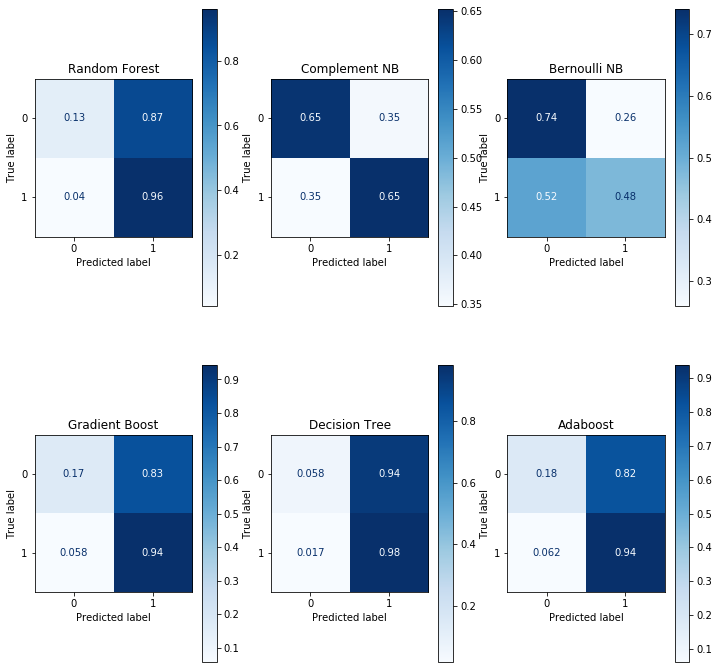

In [45]:
fig, axs = plt.subplots(2,3, figsize = (12,12))
ax = axs.flatten()

plot_confusion_matrix(model2, x_test_vect, y_test, cmap=plt.cm.Blues, normalize='true', ax = ax[0])

ax[0].set_title('Random Forest')


plot_confusion_matrix(cnb,x_test_vect, y_test, cmap = plt.cm.Blues, ax = ax[1],normalize='true')
ax[1].set_title('Complement NB')

plot_confusion_matrix(nb,x_test_vect, y_test, cmap = plt.cm.Blues, ax = ax[2],normalize='true')
ax[2].set_title('Bernoulli NB')

plot_confusion_matrix(gb,x_test_vect, y_test, cmap = plt.cm.Blues, ax = ax[3],normalize='true')
ax[3].set_title('Gradient Boost')

plot_confusion_matrix(dt, x_test_vect, y_test, cmap = plt.cm.Blues, ax = ax[4],normalize='true')
ax[4].set_title('Decision Tree')

plot_confusion_matrix(adb, x_test_vect, y_test, cmap = plt.cm.Blues, ax = ax[5],normalize='true')
ax[5].set_title('Adaboost')

plt.savefig('images/six_matrices.png')

plt.show();


## PLOT ROC CURVES ALL MODELS

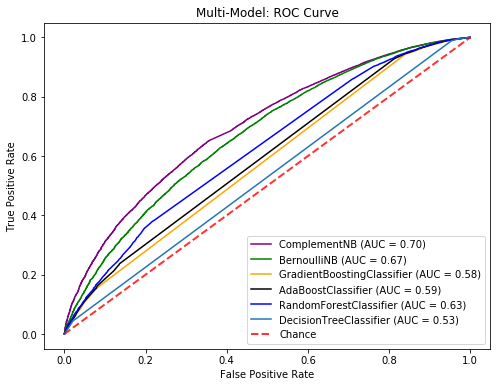

In [42]:
fig, ax = plt.subplots(1, figsize = (8,6))

plot_roc_curve(cnb, x_test_vect, y_test, ax = ax, color = 'purple')

plot_roc_curve(nb, x_test_vect, y_test, ax = ax, color = 'g')

plot_roc_curve(gb, x_test_vect, y_test, ax = ax, color = 'orange')

plot_roc_curve(adb, x_test_vect, y_test, ax = ax, color = 'black')

plot_roc_curve(model, x_test_vect, y_test, ax = ax, color = 'blue')

plot_roc_curve(dt, x_test_vect, y_test, ax = ax)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.legend()
plt.title('Multi-Model: ROC Curve')
# plt.savefig('ROC_multi_over_samp_count_v.png')
plt.show()

## PLOT PRECISION RECALL CURVES

Text(0.5, 1.0, '2-class Precision-Recall curve')

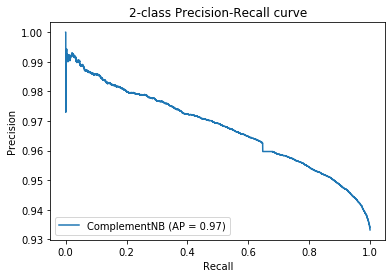

In [104]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

disp = plot_precision_recall_curve(cnb, x_test_vect, y_test)
disp.ax_.set_title('2-class Precision-Recall curve')

## ID Phrases that are mislabeled as accepted when they should be rejected

In [70]:
y_pred = cnb.predict(x_test_vect)

In [71]:
type(y_pred)

numpy.ndarray

In [72]:
examine_df = pd.concat([X_test, y_test], axis=1)
examine_df['pred_rating'] = y_pred

In [73]:
#info that was predicted to be approved but was actually rejected
FP_df = examine_df[(examine_df['rating'] == 0)&(examine_df['pred_rating'] == 1)]

#info that was prediected to be rejected but was actually approved
FN_df = examine_df[(examine_df['rating'] == 1)&(examine_df['pred_rating'] == 0)]

#info that was predicted to be rejected and was rejected
TN_df = examine_df[(examine_df['rating'] == 0)&(examine_df['pred_rating'] == 0)]
#note num645 Yikes what a disappointing article. Written by a woman no less 

# info that was predicted positive and was positive
TP_df = examine_df[(examine_df['rating'] == 1)&(examine_df['pred_rating'] == 1)]

In [74]:
fp_randoms = random.sample(range(2613), 10)

fp_samp = []
for ind, i in enumerate(fp_randoms):
    txt = FP_df.text.values[i]
    fp_samp.append(txt)
    print(f'{ind}: \n{txt} \n')

0: 
The 'human civility' thread is down the hall, second door on your right. 

1: 
I don't recall nazi's being only concerned with jews. The holocaust alone was 2 mil pols, 6mil jews, 7mil russians....goes on. I could argue with nazi sympathizers all day, but thats not the issue. 

Those people have a right to say that as do the others whom disagreed. Their views are not excluded under the non-absolution of our freedom of speech. The failure to understand our rights has led to the removal of hundreds of monuments, not just confederacy ones. Which by the way, southerns pride their right to rebel not the right to own a slave. I just think the entire thing should have been done diplomatically, not with an iron fist leading to the "facism" the one side seeks to abolish...which we don't have currently. 

We're headed down a slippery slope to the battle of defending rights and liberties against the dynamic mainstream morality on a large scale. 

2: 
How does it go? All hat and no cowboy? 

3

In [75]:
fn_randoms = random.sample(range(FN_df.rating.value_counts()[1]), 10)

fn_samp = []
for ind, i in enumerate(fn_randoms):
    txt = FN_df.text.values[i]
    fn_samp.append(txt)
    print(f'{ind}: \n{txt} \n')


0: 
They all use the same buzz words, transparency, collaboration, etc.  Nothing of substance offered except by Ballard.  Ballard should be the next chief hands down!  She oozes integrity and that's really what we want at the end of the day. 

1: 
Now here is a difficult question to answer. What is the biggest waste of time: the Liberal motion? the Conservative motion? The Globe and Media coverage of same? Me writing this post? You reading my post? All of the above (although at the least the last three don't involve a waste of tax dollars)? A difficult question to answer. 

2: 
a gov't run amuck 

3: 
That's a long winded disjointed paragraph with very little real substance. I will address the only real point you made.

"Until such time that those on the right are able to define themselves to the satisfaction of Canadians as a party that is not a mash up of reformists, big tent evangelicals, social credit dinosaurs and progressives they will fail to amass the ability to govern with any

In [76]:
tn_randoms = random.sample(range(TN_df.rating.value_counts()[0]), 10)

tn_samp = []
for ind, i in enumerate(tn_randoms):
    txt = TN_df.text.values[i]
    tn_samp.append(txt)
    print(f'{ind}: \n{txt} \n')


0: 
Proof that boys having sex with high school drama teachers does not affect long term accomplishments. 

1: 
This reporting is irresponsible. "Believed" to be LSD? How about you report on facts and not conjecture. Shameful sensationalism. 

2: 
THE degree of how lurid the abuses that were reported were in direct proportion to how much money was offered to "survivors". The people offered the most money before testifying had the most horrible tales. 

3: 
All this crap is a distraction, plain and simple.  If they want to carry the flag of losers, then let them!  It's 'Merica.  

45 is running scared and that's when his mouth starts spewing garbage. 45 is a traitor and sitting on a Russian hot seat. 

4: 
Haaaaaaaaaaaaaaaaaa! Aunty Tulsi what took you sooooooo long?
You should have gotten the memo during the primary campaign,when your "Sickle & Hammer "guy Bernie Sanders  got  Bushwacked by the dishonest DNC. But NOOOOOO! I heard only crickets, or in our case ,on the big Island....Coqu

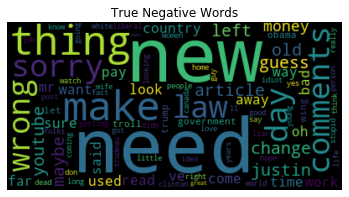

In [77]:
      
# get indices of words with highest tfidf values
snowball = SnowballStemmer(language = 'english')
port = PorterStemmer()
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english', analyzer='word', strip_accents='ascii',sublinear_tf = True)
x = TN_df.text.values
t_vect = vectorizer.fit_transform(x)
features = vectorizer.get_feature_names()

rejected_features = t_vect.toarray().mean(axis=0)
rejected_set = set(np.array(features)[rejected_features.argsort()[::-1][:100]])
plot_word_cloud(' '.join(rejected_set), title = 'True Negative Words')
#                 save_fig=True, f_name = 'tn_wordcloud.png')

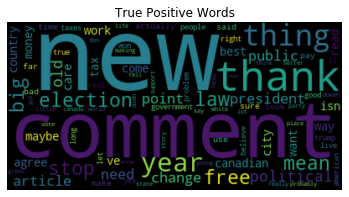

In [78]:
# get indices of words with highest tfidf values
snowball = SnowballStemmer(language = 'english')
port = PorterStemmer()
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english', analyzer='word', strip_accents='ascii',sublinear_tf = True)
x = TP_df.text.values
t_vect = vectorizer.fit_transform(x)
features = vectorizer.get_feature_names()

rejected_features = t_vect.toarray().mean(axis=0)
rejected_set = set(np.array(features)[rejected_features.argsort()[::-1][:100]])
plot_word_cloud(' '.join(rejected_set), title = 'True Positive Words')
#                 save_fig=True, f_name = 'tp_wordcloud.png')